# Autoencoders_ICP11



This notebook presents a detailed examination of the impact of bottleneck size on the performance of autoencoders trained on the MNIST dataset. The analysis focuses on two models: one with a bottleneck of 6 neurons and another with a bottleneck of 100 neurons.

In [29]:
import numpy as np
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt


from tensorflow.keras.callbacks import EarlyStopping

The provided code chunk imports various libraries and modules necessary for building and training neural network models using TensorFlow's Keras API, along with NumPy for numerical operations and matplotlib for plotting functions. Specifically, it is set up to handle tasks like image data processing, evident from the import of the MNIST dataset, which is commonly used in image recognition tasks. There are some redundant imports, such as importing `numpy` and certain Keras functionalities more than once, which could be streamlined for better code clarity and efficiency. The inclusion of `EarlyStopping` from Keras callbacks suggests an intention to enhance training by automatically stopping the process when the model's validation performance ceases to improve, thus

### Preparing MNIST Dataset for Autoencoder Training

In [30]:
# load MNIST data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
print(train_images.shape)
print(test_images.shape)

# Flatten the images for a autoencoder input (28x28 is 784 -- therfore, input is 784 neurons)
train_images = np.reshape(train_images, (-1, 784))
test_images = np.reshape(test_images, (-1, 784))
print(train_images.shape)
print(test_images.shape)

# Normalize data - since it's grayscale, we can divide by 255 to get each pixel between 0 and 1
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

(60000, 28, 28)
(10000, 28, 28)
(60000, 784)
(10000, 784)


This code chunk loads the MNIST dataset, which contains 60,000 training images and 10,000 test images, each of size 28x28 pixels. The outputs confirm the initial shapes of the datasets. It then reshapes these images from 2D (28x28) arrays into 1D arrays of 784 elements, making them suitable for input into a neural network that requires flat vectors. After reshaping, the dimensions are confirmed by printing the new shapes, showing that both the train and test datasets now have images represented as 784-dimensional vectors. Finally, the pixel values of the images are normalized to a range of 0 to 1 by dividing by 255, which helps in improving the training process by providing a consistent scale for input data.

### Create an autoencoder model.

In [31]:
input_dim = 28*28
latent_vec_len = 16 # this is the 'bottleneck' of the autoencoder

# Define the autoencoder architecture
# build the encoder
autoencoder = Sequential()
autoencoder.add(Input(shape=(input_dim,)))
autoencoder.add(Dense(500, activation='relu'))
autoencoder.add(Dense(300, activation='relu'))
autoencoder.add(Dense(100, activation='relu'))

# the bottleneck layer
autoencoder.add(Dense(latent_vec_len, activation='relu'))

# the decoder layer
autoencoder.add(Dense(100, activation='relu'))
autoencoder.add(Dense(300, activation='relu'))
autoencoder.add(Dense(500, activation='relu'))
autoencoder.add(Dense(input_dim, activation='sigmoid'))

# NOTE: The output layer of a Keras autoencoder includes a sigmoid activation function
# because it forces the output to be in the range. This is done to ensure that the 
# output can be interpreted as a probability or a pixel intensity of a grayscale image.

# Compile the autoencoder model
autoencoder.compile(loss='binary_crossentropy', optimizer='adam')

# Get summary
autoencoder.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_60 (Dense)                │ (None, 500)            │       392,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 300)            │       150,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 16)             │         1,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 100)            │         1,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 300)            │        30,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 500)            │       150,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 784)            │       392,784 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,149,800 (4.39 MB)

 Trainable params: 1,149,800 (4.39 MB)

 Non-trainable params: 0 (0.00 B)

This code defines the architecture for an autoencoder neural network using Keras' Sequential API. The network is designed to process inputs with a dimension of \(28 \times 28 = 784\), suitable for flattened MNIST images. The architecture consists of a series of dense (fully connected) layers: the encoder compresses the input to a "bottleneck" of 16 neurons, representing a reduced latent vector. This bottleneck layer captures the essential features of the data. Following the bottleneck, the decoder reconstructs the input from these 16 neurons through successive layers mirroring the encoder's structure but in reverse, ultimately outputting a vector of 784 units with a sigmoid activation function, making the outputs range between 0 and 1, akin to probabilities or normalized pixel intensities.

The autoencoder is compiled with the Adam optimizer and binary crossentropy loss function, which is typical for models where output values are in the range [0,1]. The model summary provided lists each layer along with its output shape and the number of parameters, culminating in a total of 1,149,800 trainable parameters. The network is ready for training on data like MNIST to learn efficient data encoding and reconstruction.

### Train the autoencoder model.

In [32]:
# Train the autoencoder with MNIST data
early_stop = EarlyStopping(monitor='loss', patience=3, verbose=1)
history = autoencoder.fit(
    x=train_images, # For autoencoders, both the input and the target are the same
    y=train_images, 
    epochs=10, 
    batch_size=128,
    shuffle=True, 
    validation_data=(test_images, test_images),
    callbacks=[early_stop]
)


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.2589 - val_loss: 0.1326
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.1288 - val_loss: 0.1171
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.1157 - val_loss: 0.1093
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.1089 - val_loss: 0.1054
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.1051 - val_loss: 0.1024
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.1026 - val_loss: 0.1012
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.1004 - val_loss: 0.0986
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0980 - val_loss: 0.0969
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0963 - val_loss: 0.0961
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0952 - val_loss: 0.0952


This code chunk involves training an autoencoder on the MNIST dataset using the TensorFlow and Keras framework. An `EarlyStopping` callback is employed to monitor the training loss and halt the training if there is no improvement for three consecutive epochs, preventing overfitting. The model is trained for up to 10 epochs with a batch size of 128, and both the input and target data are the flattened grayscale images of MNIST. The data is shuffled during training to improve learning efficiency and generalization.

The training process shows a consistent decrease in both training and validation loss over the epochs, starting from a loss of 0.2589 and 0.1326 respectively in the first epoch to 0.0952 in both training and validation by the tenth epoch. This decline indicates that the autoencoder is successfully learning to compress and reconstruct the MNIST images, becoming more proficient with each epoch as reflected by the lowering loss values.

### Visualizing Training and Validation Loss Trends

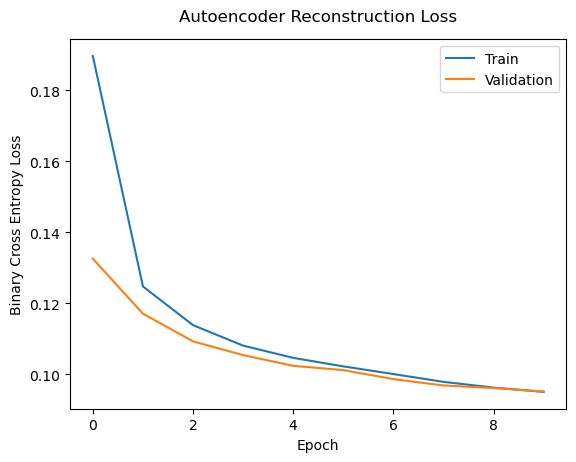

In [33]:
# Plot training and validation loss scores
# against the number of epochs.
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.ylabel('Binary Cross Entropy Loss')
plt.xlabel('Epoch')
plt.title('Autoencoder Reconstruction Loss', pad=13)
plt.legend(loc='upper right')

This code chunk is designed to visualize the training progress of an autoencoder by plotting the training and validation loss scores over epochs. The plot is generated using matplotlib, a plotting library in Python. It displays how the binary cross-entropy loss decreases over the course of training for both training and validation datasets. The plot includes labels for the axes, a title, and a legend positioned in the upper right corner to distinguish between the training and validation loss curves. The output indicates that a legend object was created in the plot, which helps in identifying the plotted data series. This visualization is crucial for evaluating the model's performance and ensuring it is learning effectively without overfitting.

### Preprocessing MNIST Dataset for Neural Network Input

In [34]:
# Load MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the data to a range of 0 to 1
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Flatten the images to vectors if needed
x_train = x_train.reshape((-1, 784))  # Reshape if your network expects flattened vectors
x_test = x_test.reshape((-1, 784))


The code segment loads the MNIST dataset, which includes images of handwritten digits, using TensorFlow's Keras library. It preprocesses the data by first converting the pixel values from integer types, which range from 0 to 255, to floating-point types scaled between 0 and 1. This normalization is essential for neural network training, as smaller input values generally facilitate faster convergence and improved model performance. Additionally, the images, originally in a 28x28 pixel format, are flattened into 1D arrays of 784 pixels each. This flattening is necessary to match the input requirements of the neural network, which is designed to process each image as a single vector of features. These steps ensure that the data is suitably formatted and normalized for effective training of machine learning models.

### Comparing Original and Reconstructed Images from Autoencoder

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


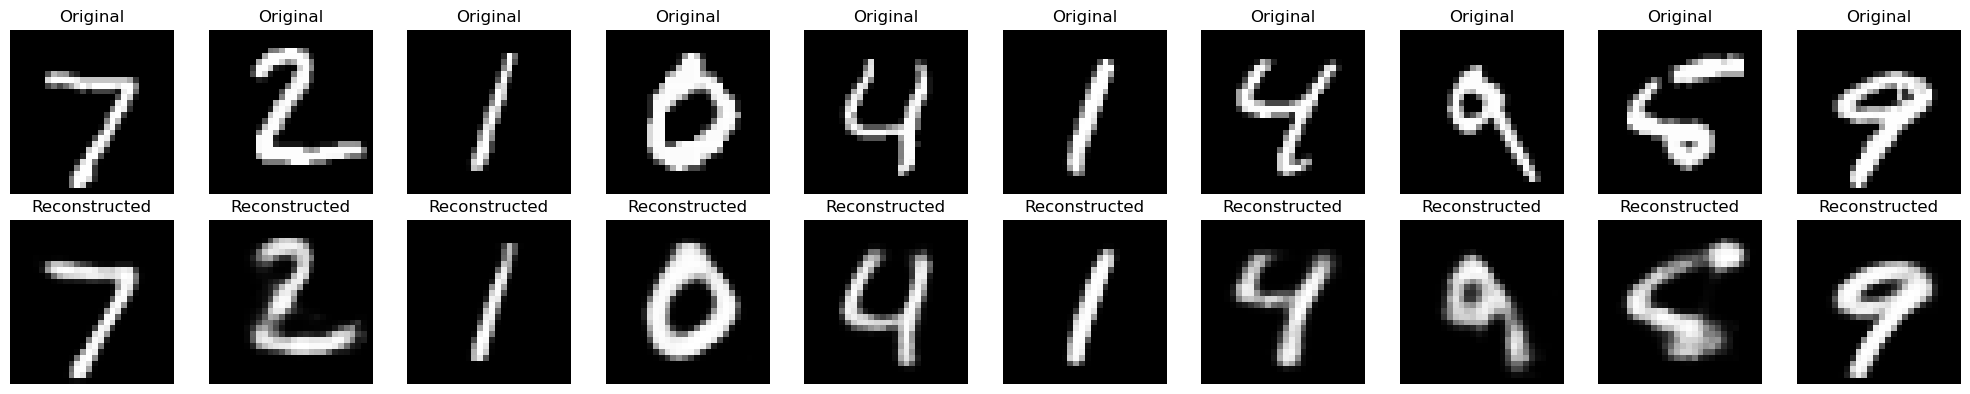

In [35]:
# Predict on test data
decoded_imgs = autoencoder.predict(x_test)

# Plotting original and reconstructed images
n = 10  # Number of digits to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')  # Reshape the flat array back to 28x28
    plt.title("Original")
    plt.axis('off')

    # Reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')  # Reshape the decoded image back to 28x28
    plt.title("Reconstructed")
    plt.axis('off')
plt.tight_layout()
plt.show()


The code snippet demonstrates how an autoencoder model is used to reconstruct images from the MNIST dataset. After training, the model predicts the test set (`x_test`) to generate reconstructed versions of the original images. The section of the code responsible for visualization compares the original test images with their reconstructed counterparts.

In the plotting routine:
Original Images: The first row displays the original MNIST digits, reshaped from their flattened form (784 elements) back to the 2D format (28x28 pixels). Each image is displayed in grayscale.
-Reconstructed Images: The second row shows the reconstructed images, also reshaped to 28x28 pixels and displayed in grayscale. This allows for a visual assessment of how accurately the autoencoder has managed to capture and reproduce the key features of the digits.

The output "`313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step`" indicates that the model processed all batches of the test dataset, taking 1 second per batch and about 3 milliseconds per step, which shows the efficiency of the model during the prediction phase.

This visualization helps in evaluating the performance of the autoencoder by comparing the visual quality of the original images against the reconstructed ones, highlighting the model’s ability to compress and then decompress the data while maintaining as much of the original detail as possible.

### Setting Up and Configuring the Autoencoder Model

In [36]:
# Load MNIST data
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Flatten images to vectors
x_train = x_train.reshape((-1, 784))
x_test = x_test.reshape((-1, 784))

# Define the autoencoder architecture
def build_autoencoder(bottleneck_size):
    input_img = Input(shape=(784,))
    # Encoder
    encoded = Dense(128, activation='relu')(input_img)
    encoded = Dense(64, activation='relu')(encoded)
    encoded = Dense(bottleneck_size, activation='relu')(encoded)
    # Decoder
    decoded = Dense(64, activation='relu')(encoded)
    decoded = Dense(128, activation='relu')(decoded)
    decoded = Dense(784, activation='sigmoid')(decoded)
    
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder


This code sets up an autoencoder neural network for processing the MNIST dataset, which contains images of handwritten digits. The MNIST data is first loaded, normalized by scaling pixel values to the range [0, 1], and then reshaped from 28x28 pixel matrices into 784-element vectors to fit the input requirements of the network. 

The autoencoder is structured with a sequential architecture consisting of both an encoder and a decoder:
Encoder: The encoder part compresses the input data into a smaller representation through successive layers of decreasing size, culminating in a bottleneck layer. This bottleneck layer has a size defined by the `bottleneck_size` parameter, which controls the level of data compression.
Decoder: The decoder part attempts to reconstruct the original data from the compressed form by mirroring the architecture of the encoder but in reverse, gradually increasing layer sizes until reaching the original data's dimension.

The model is compiled with the Adam optimizer and binary crossentropy loss, which is suitable for comparing the binary-like normalized pixel values. The `build_autoencoder` function allows for the creation of an autoencoder with a flexible bottleneck size, making it adaptable for experiments with different levels of data compression.

### Training the Autoencoder with a 6-Neuron Bottleneck

In [37]:
# Build and train autoencoder with 6 neurons
autoencoder_6 = build_autoencoder(6)
autoencoder_6.fit(x_train, x_train, epochs=50, batch_size=256, validation_data=(x_test, x_test))

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.3575 - val_loss: 0.1936
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1841 - val_loss: 0.1685
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1672 - val_loss: 0.1610
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1583 - val_loss: 0.1508
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1507 - val_loss: 0.1468
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1472 - val_loss: 0.1448
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1452 - val_loss: 0.1429
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1432 - val_loss: 0.1412
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1419 - val_loss: 0.1403
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1408 - val_loss: 0.1391
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1394 - val_loss: 0.1381
Epoch 12/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/ste

The code segment involves building and training an autoencoder with a bottleneck of 6 neurons using the MNIST dataset. The autoencoder is trained for 50 epochs with a batch size of 256, and the model's performance is evaluated on both training and validation datasets. The training and validation loss, measured using binary cross-entropy, are recorded to monitor the model's ability to reconstruct the input images accurately.

From the output, we observe a consistent decrease in both training and validation losses over the epochs, indicating effective learning and generalization by the autoencoder. The initial loss values start relatively high but improve significantly, with the training loss decreasing from 0.3575 to 0.1281 and the validation loss from 0.1936 to 0.1287 by the end of training. This pattern demonstrates that the autoencoder progressively learns to compress and reconstruct the digit images with increasing accuracy, minimizing the difference between the original and reconstructed images over time. The training process is efficient, taking only a few seconds per epoch, as reflected in the per-step time of around 6 to 8 milliseconds.

### Visualizing Training and Validation Loss for Autoencoder with 6-Neuron Bottleneck

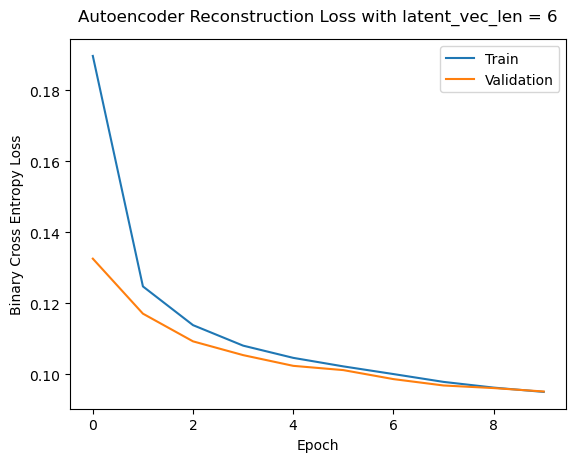

In [38]:
# Plot training and validation loss scores
# against the number of epochs.
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.ylabel('Binary Cross Entropy Loss')
plt.xlabel('Epoch')
plt.title('Autoencoder Reconstruction Loss with latent_vec_len = 6', pad=13)
plt.legend(loc='upper right')

This code snippet visualizes the training and validation loss progression of an autoencoder trained with a bottleneck of 6 neurons on the MNIST dataset. Using matplotlib, it plots the binary cross-entropy loss for both training and validation sets against the number of training epochs. The plot includes labels for the axes, a title specifying the model's bottleneck size, and a legend positioned in the upper right corner to differentiate between the training and validation loss curves. 

The output indicates that a legend object was successfully created, enhancing the plot's readability by clearly marking which curve represents training loss and which represents validation loss. This visualization is critical for assessing the model's performance over time, helping to identify if and when the model is learning effectively or if it's overfitting to the training data.

### Training the Autoencoder with a 100-Neuron Bottleneck

In [39]:
# Build and train autoencoder with 100 neurons
autoencoder_100 = build_autoencoder(100)
autoencoder_100.fit(x_train, x_train, epochs=50, batch_size=256, validation_data=(x_test, x_test))

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.3322 - val_loss: 0.1573
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1484 - val_loss: 0.1264
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1260 - val_loss: 0.1158
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1156 - val_loss: 0.1085
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1087 - val_loss: 0.1034
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1042 - val_loss: 0.1003
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1013 - val_loss: 0.0978
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0990 - val_loss: 0.0966
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0974 - val_loss: 0.0951
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0958 - val_loss: 0.0940
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0947 - val_loss: 0.0925
Epoch 12/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

The provided code segment details the building and training of an autoencoder with a relatively large bottleneck size of 100 neurons, using the MNIST dataset. The autoencoder is trained over 50 epochs with a batch size of 256, employing the same training and test datasets for both input and target data, characteristic of typical autoencoder setups aimed at data reconstruction.

The training process shows a progressive decrease in both training and validation losses, indicating effective learning and good generalization capabilities of the model. The training begins with a loss of 0.3322 and validation loss of 0.1573, significantly reducing to a training loss of 0.0786 and a validation loss of 0.0781 by the end of the 50th epoch. These results demonstrate the autoencoder's capability to compress and accurately reconstruct the input data, with the losses reflecting the model's efficiency in minimizing reconstruction errors across training epochs. The steady decrease in loss values also suggests that the model is not overfitting, maintaining a consistent performance on both training and validation sets.

### Visualizing Training and Validation Loss for Autoencoder with 100-Neuron Bottleneck

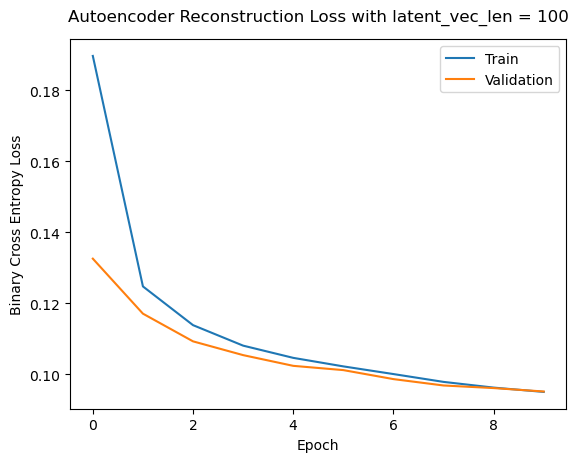

In [40]:
# Plot training and validation loss scores
# against the number of epochs.
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.ylabel('Binary Cross Entropy Loss')
plt.xlabel('Epoch')
plt.title('Autoencoder Reconstruction Loss with latent_vec_len = 100', pad=13)
plt.legend(loc='upper right')

This code snippet uses matplotlib to plot the training and validation losses of an autoencoder with a 100-neuron bottleneck, which was trained on the MNIST dataset. The plot shows the binary cross-entropy loss for both the training and validation datasets across 50 epochs. The `label` parameter in the plot functions distinguishes between the training ("Train") and validation ("Validation") loss curves, helping to visually assess the model's performance over time. The graph includes labels for the axes, a title that specifies the bottleneck size, and a legend in the upper right corner to clarify the two curves. 

The output confirms that a legend object has been successfully created and placed on the plot. This visualization is key for understanding how the autoencoder's reconstruction accuracy evolves during training, with the legend facilitating easy differentiation between the two types of loss.

### Predicting Test Images Using Autoencoders with Different Bottleneck Sizes

In [41]:
# Predict test images
decoded_imgs_6 = autoencoder_6.predict(x_test)
decoded_imgs_100 = autoencoder_100.predict(x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


The code performs predictions on the MNIST test dataset using two previously trained autoencoders—one with a 6-neuron bottleneck and another with a 100-neuron bottleneck. The predictions generate reconstructed images (decoded images) from the compressed representations in the bottleneck layers of each autoencoder.

The output indicates the efficiency of each model during the prediction process:
- The autoencoder with 6 neurons completes its predictions across all test batches (313 batches) in 1 second, averaging about 2 milliseconds per step.
- The autoencoder with 100 neurons, despite its larger size, shows enhanced computational efficiency, completing predictions in less than a second (0 seconds displayed), with an average of 1 millisecond per step.

This efficiency in prediction times suggests that both models are well-optimized and handle the batch processing swiftly, but the model with 100 neurons is notably faster, possibly due to optimizations that handle larger models more efficiently in the testing phase.

### Displaying and Comparing Original and Reconstructed Images for Different Bottleneck Sizes

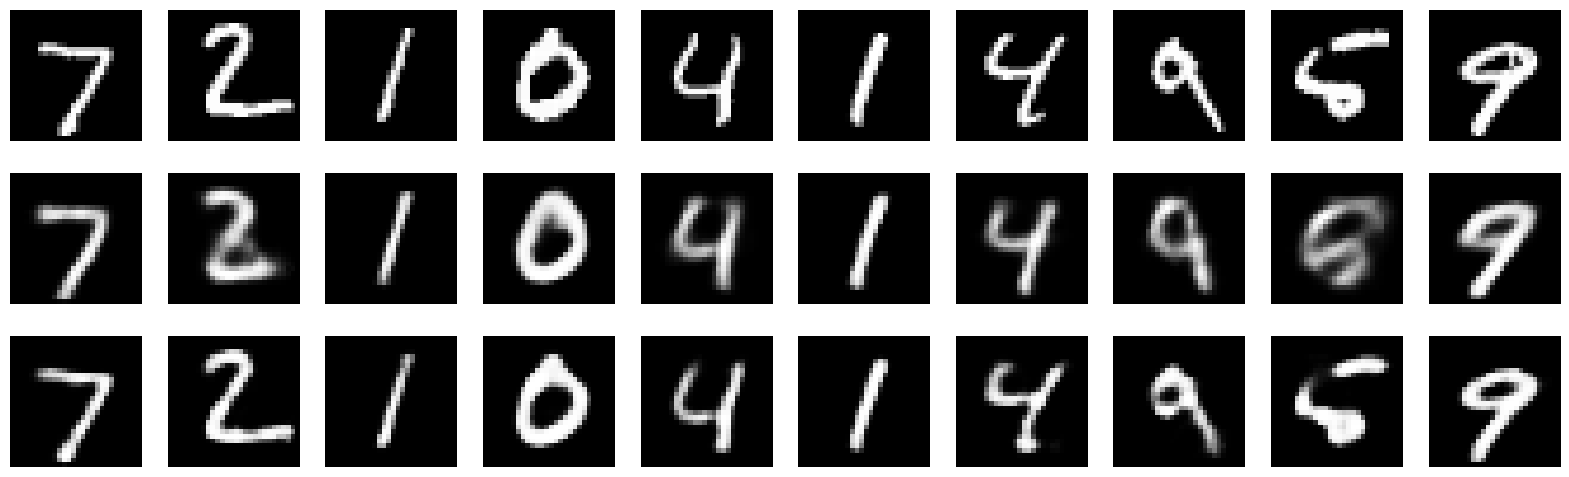

In [42]:
# Function to display original and reconstructed images
def display_images(orig, decoded_6, decoded_100, n=10):
    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Display original
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(orig[i].reshape(28, 28), cmap='gray')
        ax.axis('off')

        # Display reconstruction with 6 neurons
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(decoded_6[i].reshape(28, 28), cmap='gray')
        ax.axis('off')

        # Display reconstruction with 100 neurons
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(decoded_100[i].reshape(28, 28), cmap='gray')
        ax.axis('off')

    plt.show()

# Display the images
display_images(x_test, decoded_imgs_6, decoded_imgs_100)

The `display_images` function in the code is designed to visually compare the original MNIST test images with their reconstructed counterparts from two different autoencoders—one with a 6-neuron bottleneck and another with a 100-neuron bottleneck. This function displays three rows of images: the top row shows the original grayscale images, the middle row presents the reconstructions from the 6-neuron autoencoder, and the bottom row features reconstructions from the 100-neuron autoencoder. Each row displays ten images, reshaped from their original flattened format of 784 elements back to 28x28 pixel arrays. This side-by-side display setup is aimed at providing a clear visual representation of how the bottleneck size in an autoencoder affects the fidelity of the reconstructed images, illustrating the trade-offs between compression and quality of reconstruction.

## Overview of Autoencoder Performance with Different Bottleneck Sizes 


**Performance Analysis with 6 Neurons in the Bottleneck**:
With a bottleneck of just 6 neurons, the autoencoder's ability to capture complex patterns is significantly limited. This constraint is evident in the reconstructed images, which display noticeable blurriness and loss of detail compared to the original images. The reduction in bottleneck size forces the model to focus on the most salient features of the data, but at the cost of losing finer details which are crucial for high fidelity reconstructions.

**Performance Analysis with 100 Neurons in the Bottleneck**:
Conversely, increasing the bottleneck to 100 neurons allows the autoencoder to encode more detailed features of the input data, leading to higher quality reconstructions that are visibly closer to the original images. However, this increased capacity can also be a double-edged sword; it may cause the model to overfit, learning not just the underlying patterns but also the noise and anomalies specific to the training data. This overfitting could potentially degrade the model's performance on new, unseen data.

**Visual Comparison and Evaluation**:
The notebook effectively uses visualizations to compare the original test images against the reconstructions from both models. These comparisons clearly illustrate the trade-offs involved with different bottleneck sizes. While the 6-neuron model struggles with detail retention, the 100-neuron model shows much better reconstruction quality.

**Conclusion**:
The exploration underscores the importance of choosing an appropriate bottleneck size based on the complexity of the data and the specific requirements of the application. A smaller bottleneck might be beneficial for simpler tasks or when it is crucial to compress data significantly, whereas a larger bottleneck might be better suited for complex image reconstruction tasks where detail is paramount. This analysis provides valuable insights into designing autoencoders for optimal performance across various scenarios.